# Fixed Bias Sampler

Gibbs sampler for the reporter model where each weekday is assigned a fixed reporting bias $\alpha_{w[t]}$, which does not vary over time and is independant of other days. This scales the true case/death number on each day to give the recorded count.

## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from synthetic_data import RenewalModel, Reporter

In [2]:
# Simulate Renewal Model
time_steps = 300; N_0 = 100; R_0=0.9; seed=31
start_date = '01/01/2020'; bias_method = 'poisson'
bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first

np.random.seed(seed)
model = RenewalModel(R0=R_0)
model.simulate(T=time_steps, N_0=N_0)

100%|██████████| 300/300 [00:00<00:00, 144018.68it/s]


In [3]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

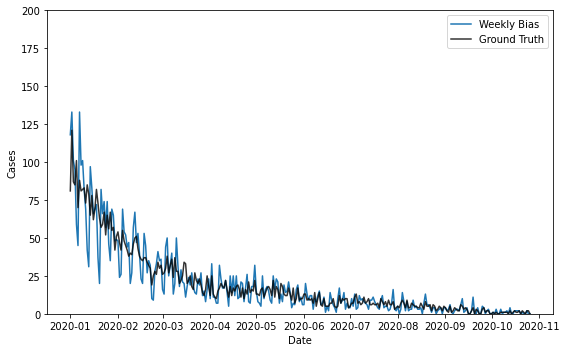

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
# fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_data_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_seed_{seed}.png")

## Fixed Bias Formulation

The simplest form of this formulation is when $C_{t} = \alpha_{w[t]} I_{t}$ - i.e. the ground truth cases are scaled by some weekday-dependant scalar constant to give the observed cases. To generate sufficient noise in the periodicity of the observed (recorded) data however, we use $C_{t} \sim Po(\alpha_{w[t]} I_{t})$, while the true cases are still given by the renewal equation $I_{t} \sim Po(R_{t} \Lambda_{t})$. Note that this model is not mechanistic, and there is no requirement imposed that the number of cases is conserved across the reporting process (i.e. that valules of $\alpha_{i}$ average to unity), although the inference process tends not to deviate far from this.

The parameters are updated in two steps. First each time step $I_{t}$ is sampled independantly from the following distribution:

$$
P(I_{t} | C_{t}, \alpha_{i}, R_{t}) =  Po(I_{t} | R_{t} \Lambda_{t}) \times Po(C_{t} | \alpha_{i}I_{t})
$$

N.B For $t=0$, $\Lambda_{t}$ is not defined, and therefore we take $\Lambda_{0} = C_{0}\alpha_{0}$ as an estimate of the seed cases instead during inference.

Secondly, $\alpha_{i}$ are updated using Gibbs sampling from the following conditional probability:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{1, 8, 15, ...} Po(C_{t} | \alpha_{i} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

summing over all days of that given weekday (monday indicies illustrated). This may be simplified to a single Gamma distribution using a known conditional prior relation (noting that the rates of the two processes differ by a scalar $I_{t}$ and so this is not quite equal to the standard relation). The prior of $\alpha_{i}$ is given by a Gamma distribution $Gamma(a, b)$.


### Conjugate Priors for $\alpha_{i}$

As above, the conditional posterior for $\alpha_{i}$ is given by:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

where we only consider times corresponding to a single weekday (i.e. $t = {1, 8, 15...}$ for $i = 1$).

The product may be written as:

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) = \prod_{t} (\alpha_{i[t]}I_{t})^{C_{t}} \times \frac{e^{-\alpha_{i[t]} I_{t}}}{C_{t}!}
$$

which we may simplify to (also removing the constant factorial $C_{t}!$):

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \prod_{t} I_{t}^{C_{t}}
$$

Combining this with the explicit form of the gamma prior, we may therefore write that:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \alpha_{i[t]} \! ^{a-1} \times e^{-b\alpha_{i[t]}} \times \prod_{t} I_{t}^{C_{t}} 
$$

Collecting like terms, and removing the multiplicative constant $\prod_{t} I_{t}^{C_{t}}$, we arrive at the final result:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{(a + \sum_{t=i}^{n}C_{t}) - 1} \times e^{ - \alpha_{i[t]} \left(b + \sum_{t=i}^{n}I_{t}\right)}
$$

which is in the form of a Gamma distribution:

$$
P(\alpha_{i} | I_{t} , C_{t}) \sim Gamma \left(a + \sum_{t=i}^{n}C_{t}, b + \sum_{t=i}^{n}I_{t} \right)
$$


## Posterior Distribution Generation
In this section, we apply the above formulation to conduct inference.

In [5]:
from sampling_methods import GibbsParameter, MixedSampler
from periodic_model import truth_parameter, bias_parameter, fixed_r_parameter

In [6]:
I_data = list(bias_df['Confirmed'])

params = {'bias_prior_alpha': 1, 'bias_prior_beta': 1,
          'rt_prior_alpha': 1, 'rt_prior_beta': 1}  # Gamma dist
params['serial_interval'] = RenewalModel(R0=None).serial_interval

for i, val in enumerate(I_data):  # Observed cases - not a Parameter
    params[("data_" + str(i))] = val

data_initial_guess = sum(I_data)/len(I_data)  # Constant initial value
for i in range(0, len(I_data)):  # Ground truth data
    params[("truth_" + str(i))] = truth_parameter(data_initial_guess, index=i)

for i in range(7):  # Weekday bias parameters
    params[("bias_" + str(i))] = bias_parameter(1, index=i)

params['R_t'] = fixed_r_parameter(value = 1) # Optional parameter- can replace with float R_0

step_num = 50
sampler = MixedSampler(params=params)
output = sampler.sampling_routine(step_num=step_num, sample_burnin=1)

filename = f"synth_inference_T_{bias_method}_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.csv"
output.to_csv('../data/outputs/' + filename)

100%|██████████| 50/50 [02:05<00:00,  2.50s/it]


In [7]:
# # Read in old dataset

# output = pd.read_csv("../data/outputs/synth_inference_T_poisson_600_N0_100_R0_0.99_It_300_seed_32.csv")
# bias_method = 'poisson'; time_steps = 600; N_0 = 100; R_0 = 0.99; step_num = 300; seed = 32

# np.random.seed(seed); model = RenewalModel(R0=R_0); model.simulate(T=time_steps, N_0=N_0)

# rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease
# truth_df = rep.unbiased_report(); bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

## Output Visualisation

Mean bias values: [0.6, 1.4, 1.1, 1.1, 0.9, 1.0, 0.6]
True bias values: [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]


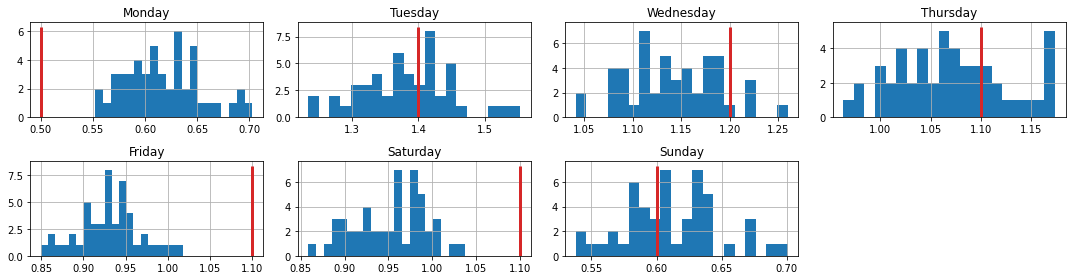

In [8]:
start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday()
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=20, figsize=(15, 4), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biases_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seeds_{seed}.png")

print("Mean bias values: " + str(output_bias))
print(f"True bias values: {bias}")

In [9]:
for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 2)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 2)
    print(f"Bias_{i}: {mean} +/- {std}")

Bias_0: 0.62 +/- 0.04
Bias_1: 1.38 +/- 0.07
Bias_2: 1.14 +/- 0.05
Bias_3: 1.07 +/- 0.05
Bias_4: 0.93 +/- 0.04
Bias_5: 0.95 +/- 0.04
Bias_6: 0.61 +/- 0.04


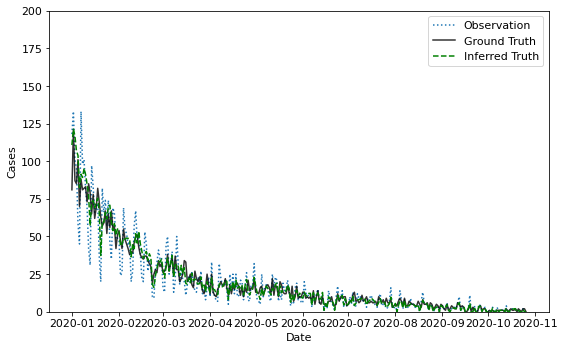

In [10]:
# Apply bias to first value which was previously matched to data
# predicted_truth = [params['truth_0'] / np.mean(output['bias_0'])]  
plt.rcParams['font.size'] = '11'
predicted_truth = []  

for index in range(0, time_steps):
    predicted_truth.append(np.mean(output['truth_' + str(index)]))

# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
axs.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")

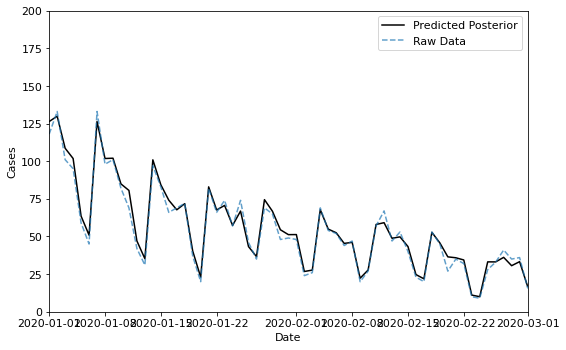

In [11]:
predicted_posterior = [np.mean(output['truth_' + str(i)]) * np.mean(output['bias_' + str(int(i % 7))])
                   for i in range(0, time_steps)]  

# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

axs.plot(truth_df['Date'], predicted_posterior, color='black', label = 'Predicted Posterior')
bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Raw Data', linestyle = 'dashed', alpha=0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.xlim('01/01/2020', '03/01/2020')  # Neccessary on longer time series to see small differences
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"predicted_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")

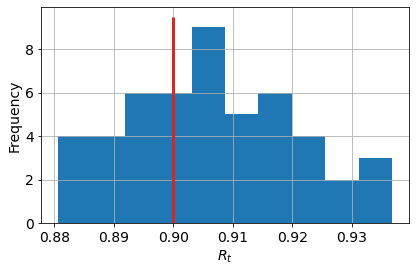

In [12]:
if ('R_t' in output.columns and isinstance(params['R_t'], GibbsParameter)):
    plt.rcParams['font.size'] = '14'

    histo = output.hist('R_t')
    histo[0, 0].vlines(x=R_0, ymin=0, ymax=histo[0, 0].get_ylim()[1], color='tab:red', linewidth=3)
    plt.xlabel('$R_{t}$'); plt.ylabel('Frequency'); plt.title('');
    plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
    # plt.savefig("../images/synthetic_inference/constant_R/"
    #             + f"Rt_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")

## Inferred Timeseries Accuracy

This section contains methods to quantify the accuracy of the inferred timeseries, in comparison to both the biased timeseries, and a rolling 7 day average method (the government standard).

In [13]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

RMS Residual for Biased data: 9.56
RMS Residual for Rolling Average data: 4.5
RMS Residual for Bayesian Inference data: 4.92


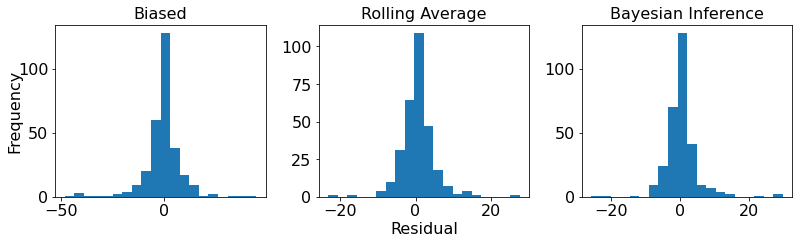

In [14]:
roll_ave_series = bias_df['Confirmed'].rolling(window=7, center = False).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: -0.30 days
Expected lag for Rolling Average data: -0.46 days
Expected lag for Bayesian Inference data: -3.25 days


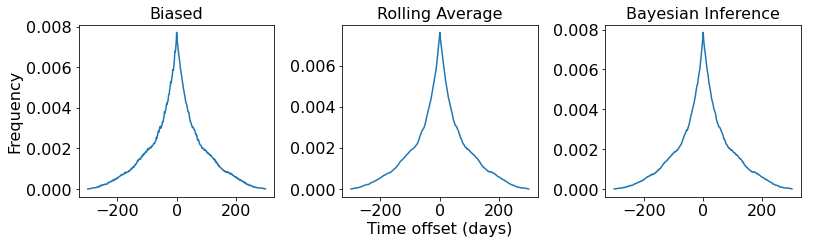

In [15]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    # axs[i].set_xlim(-7, 7); axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    expected_lag = np.dot(t_values, cross_corr)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_It_{step_num}_seed_{seed}.png")